# Recurrent Neural Network - RNN

Importing the required libraries:

In [2]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math

In [3]:
os.chdir('/Users/mariapiabellini/Desktop/Unicatt/Time series/project')
ts = pd.read_csv('HortonGeneralHospital 2.csv', header=0, index_col=0, parse_dates=True).squeeze("columns")

/var/folders/cl/2n2m21_9053fvwntblb1fmwm0000gn/T/ipykernel_5156/3043979079.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.read_csv('HortonGeneralHospital 2.csv', header=0, index_col=0, parse_dates=True).squeeze("columns")


In [4]:
adm_ts=ts.iloc[:,3:6]
adm_ts

,Adm,year,month
1,413,1999,11
2,443,1999,12
3,378,2000,1
4,385,2000,2
5,388,2000,3
...,...,...,...
135,541,2011,1
136,457,2011,2
137,560,2011,3
138,514,2011,4


In [5]:
adm_ts.loc[:,'date'] = pd.to_datetime(ts[['year', 'month']].assign(day=1))
adm_ts.loc[:,'date'] = adm_ts['date'].dt.to_period('M')
adm_ts

/var/folders/cl/2n2m21_9053fvwntblb1fmwm0000gn/T/ipykernel_5156/549218275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm_ts.loc[:,'date'] = pd.to_datetime(ts[['year', 'month']].assign(day=1))


,Adm,year,month,date
1,413,1999,11,1999-11
2,443,1999,12,1999-12
3,378,2000,1,2000-01
4,385,2000,2,2000-02
5,388,2000,3,2000-03
...,...,...,...,...
135,541,2011,1,2011-01
136,457,2011,2,2011-02
137,560,2011,3,2011-03
138,514,2011,4,2011-04


## Splitting data 
We split the data 80%/20% into the Training set and the Test set.

In [6]:
training_data_len = math.ceil(len(adm_ts) * .8)
training_data_len 

train_data = adm_ts[:training_data_len].iloc[:,:1] 
test_data = adm_ts[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(112, 1) (27, 1)


## Re-shaping the arrays

In [7]:
dataset_train = train_data.Adm.values 
dataset_test = test_data.Adm.values 
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_test = np.reshape(dataset_test, (-1,1)) 
print(dataset_train.shape, dataset_test.shape)

(112, 1) (27, 1)


## Data Normalization

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test) 
print(scaled_train[:5])
print(scaled_test[:5])

[[0.10115607]
 [0.18786127]
 [0.        ]
 [0.02023121]
 [0.02890173]]
[[0.8869258 ]
 [0.78798587]
 [1.        ]
 [0.65371025]
 [0.6819788 ]]


## Time Series data

In [9]:
X_train = []
y_train = []
for i in range(20, len(scaled_train)):
    X_train.append(scaled_train[i-20:i, 0])
    y_train.append(scaled_train[i, 0])

In [10]:
X_test = []
y_test = []
for i in range(20, len(scaled_test)):
    X_test.append(scaled_test[i-20:i, 0])
    y_test.append(scaled_test[i, 0])

## Trasforming the data for RNN

In [11]:
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (92, 20, 1) y_train : (92, 1)


In [12]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_test : (7, 20, 1) y_test : (7, 1)


In [13]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [14]:
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 20, activation = "tanh",return_sequences = True,input_shape = (X_train.shape[1],1)))

regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 20, activation = "tanh",return_sequences = True))

regressor.add(SimpleRNN(units = 20,activation = "tanh",return_sequences = True))

regressor.add( SimpleRNN(units = 20))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

## Compiling the model

In [15]:
regressor.compile(optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01,decay=1e-6, momentum=0.9, nesterov=True), loss = "mean_squared_error")

# fitting the model
regressor.fit(X_train, y_train, epochs = 20, batch_size = 2)
regressor.summary()

Epoch 1/20
46/46 [==============================] - 1s 3ms/step - loss: 0.0429
Epoch 2/20
46/46 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 3/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0376
Epoch 4/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 5/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0310
Epoch 6/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0283
Epoch 7/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0229
Epoch 8/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0230
Epoch 9/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 10/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 11/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0211
Epoch 12/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 13/20
46/46 [==============================

## Prediction

In [16]:
y_RNN = regressor.predict(X_test)

1/1 [==============================] - 0s 132ms/step


In [17]:
y_RNN_O = scaler.inverse_transform(y_RNN) 

ValueError: x and y must have same first dimension, but have shapes (27,) and (7, 1)

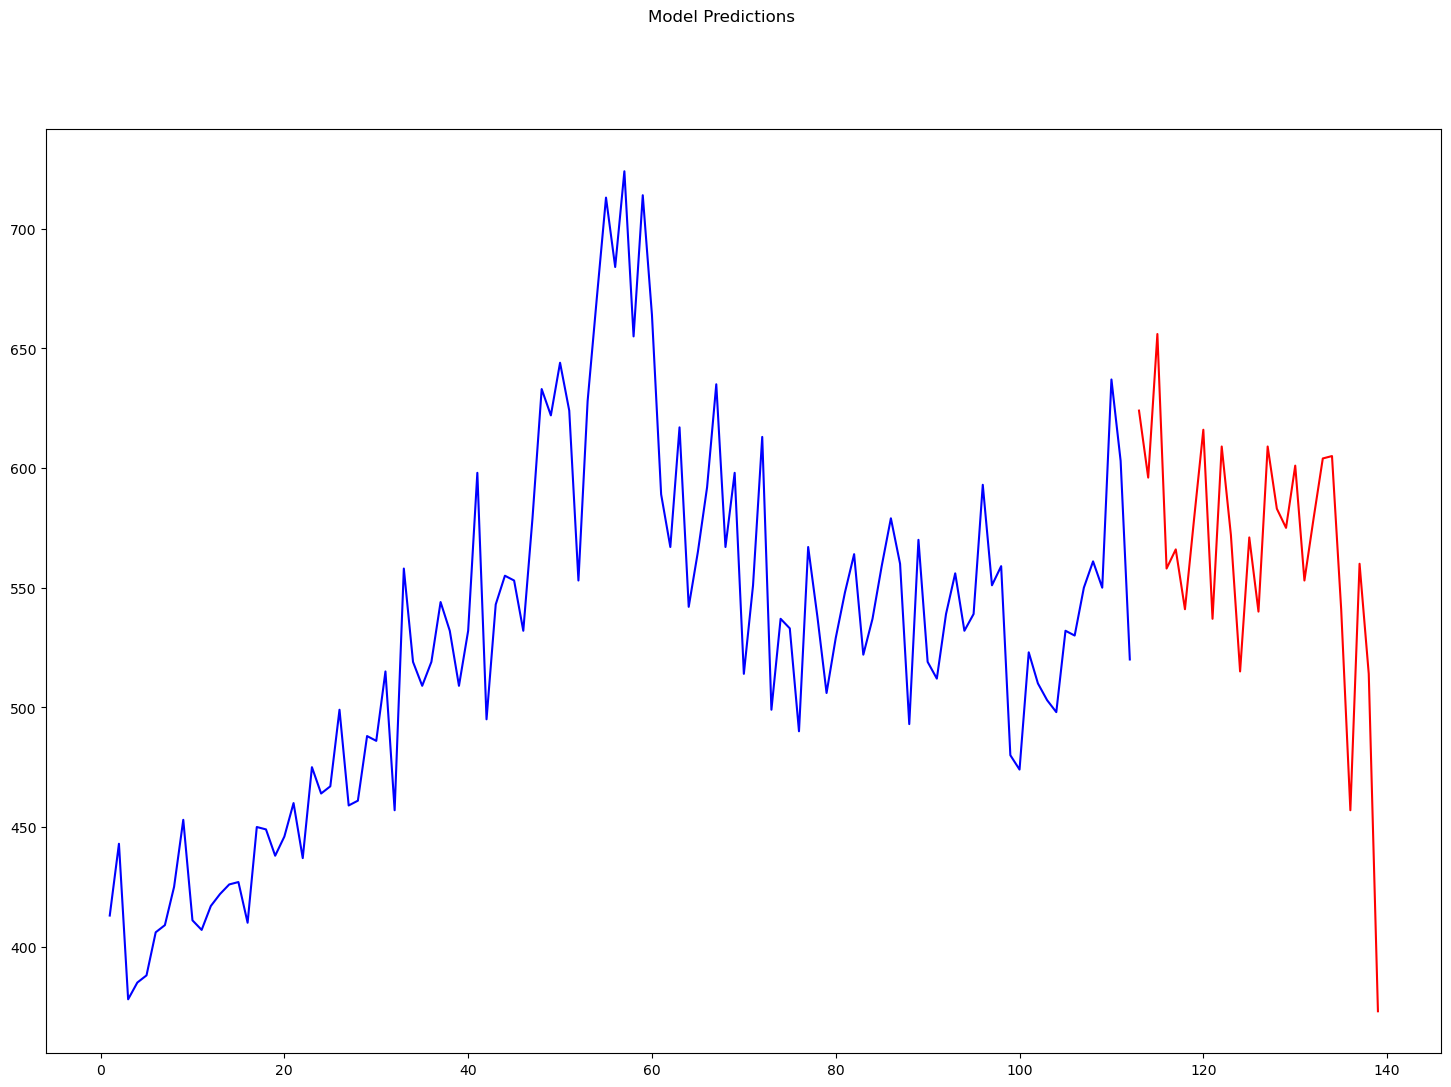

In [18]:
fig, axs = plt.subplots(1,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
plt.plot(train_data.index, train_data.Adm, label = "train_data", color = "b")
plt.plot(test_data.index, test_data.Adm, label = "test_data", color = "r")
plt.plot(test_data.index, y_RNN_O, label = "y_RNN", color = "yellow")
plt.legend()
plt.title("Basic RNN")

plt.xlabel("Years")
plt.ylabel("Adm")

plt.show()

## Regression with Keras
Our target variable is Adm, so the regressors will be Cardio, Resp and Hypo.

In [20]:
columns = ts.columns

predictors = ts[columns[columns != 'Adm']] # all columns except Strength
target = ts['Adm'] # Strength column

In [24]:
predictors.head()

,Cardio,Resp,Hypo,year,month
1,1,0,0,1999,11
2,1,0,0,1999,12
3,1,0,0,2000,1
4,0,0,0,2000,2
5,1,0,0,2000,3


In [25]:
target.head()

1    413
2    443
3    378
4    385
5    388
Name: Adm, dtype: int64

* Normalizing the data

In [26]:
predictors_norm = (predictors - predictors.mean()) / predictors.std()
n_cols = predictors_norm.shape[1]
predictors_norm.head()

,Cardio,Resp,Hypo,year,month
1,0.160253,-0.444985,-0.306282,-1.817441,1.299653
2,0.160253,-0.444985,-0.306282,-1.817441,1.585043
3,0.160253,-0.444985,-0.306282,-1.520933,-1.554246
4,-1.012122,-0.444985,-0.306282,-1.520933,-1.268856
5,0.160253,-0.444985,-0.306282,-1.520933,-0.983466


In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [30]:
def regression_model():
    # create model
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
model = regression_model()

* Fitting the model

In [31]:
model.fit(predictors_norm, target, validation_split=0.3, epochs=100, verbose=2)

Epoch 1/100
4/4 - 0s - loss: 283682.8438 - val_loss: 309214.6250 - 152ms/epoch - 38ms/step
Epoch 2/100
4/4 - 0s - loss: 283477.1250 - val_loss: 309034.0625 - 9ms/epoch - 2ms/step
Epoch 3/100
4/4 - 0s - loss: 283283.0000 - val_loss: 308856.7500 - 9ms/epoch - 2ms/step
Epoch 4/100
4/4 - 0s - loss: 283093.3750 - val_loss: 308676.3125 - 10ms/epoch - 3ms/step
Epoch 5/100
4/4 - 0s - loss: 282905.0000 - val_loss: 308498.5312 - 10ms/epoch - 2ms/step
Epoch 6/100
4/4 - 0s - loss: 282712.4375 - val_loss: 308315.0000 - 10ms/epoch - 3ms/step
Epoch 7/100
4/4 - 0s - loss: 282508.2812 - val_loss: 308126.0625 - 11ms/epoch - 3ms/step
Epoch 8/100
4/4 - 0s - loss: 282299.1250 - val_loss: 307933.1562 - 9ms/epoch - 2ms/step
Epoch 9/100
4/4 - 0s - loss: 282072.0938 - val_loss: 307734.5938 - 11ms/epoch - 3ms/step
Epoch 10/100
4/4 - 0s - loss: 281828.3750 - val_loss: 307523.3750 - 10ms/epoch - 2ms/step
Epoch 11/100
4/4 - 0s - loss: 281562.9688 - val_loss: 307294.6875 - 10ms/epoch - 3ms/step
Epoch 12/100
4/4 - 0

Epoch 93/100
4/4 - 0s - loss: 50427.4805 - val_loss: 153667.7188 - 10ms/epoch - 2ms/step
Epoch 94/100
4/4 - 0s - loss: 49098.0625 - val_loss: 151188.1719 - 10ms/epoch - 2ms/step
Epoch 95/100
4/4 - 0s - loss: 48026.4648 - val_loss: 148819.5938 - 10ms/epoch - 2ms/step
Epoch 96/100
4/4 - 0s - loss: 47135.1992 - val_loss: 146416.8750 - 10ms/epoch - 2ms/step
Epoch 97/100
4/4 - 0s - loss: 46112.1250 - val_loss: 143726.8594 - 9ms/epoch - 2ms/step
Epoch 98/100
4/4 - 0s - loss: 45053.1992 - val_loss: 140933.4531 - 10ms/epoch - 2ms/step
Epoch 99/100
4/4 - 0s - loss: 43911.1797 - val_loss: 138358.2500 - 10ms/epoch - 2ms/step
Epoch 100/100
4/4 - 0s - loss: 43010.5078 - val_loss: 135900.9219 - 9ms/epoch - 2ms/step


The term 'loss' represents the value of the cost function calculated using the training data, while 'val_loss' denotes the value of the cost function computed using the cross-validation data.